In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import numpy as np
from scipy.stats import zscore
from scipy.special import logit
from IPython.core.pylabtools import figsize

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests

from sklearn.decomposition import PCA

In [2]:
data_dir = '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/'
# data_dir = '../../data/'
tiklova_mrna_event = pd.read_csv(data_dir + 'tiklova_neurogenesis/mrna_per_event.tab', sep='\t', index_col=0)
tiklova_neurogenesis_rd = pd.read_csv(data_dir + 'tiklova_neurogenesis/rd_pc2.tab', sep='\t', index_col=0)
tiklova_PSI = pd.read_csv(data_dir + 'tiklova_neurogenesis/skipped_exons_psi.tab', sep='\t', index_col=0)
tiklova_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.scores.txt', sep='\t', index_col=0)
tiklova_cross_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.cross_scores.tab', sep='\t', index_col=0)
tiklova_kw = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)
# tiklova_kw = pd.read_csv(data_dir + 'tiklova_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)
tiklova_mrna = pd.read_csv('/mnt/lareaulab/cfbuenabadn/data_sc_regulation/tiklova/mrna_counts.tab', sep='\t', index_col=0)[tiklova_neurogenesis_rd.index]

geary_C = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_autocor_one_matrix/tiklova_GearyC_k100.tab',
                     sep='\t', index_col=0)

geary_C.columns = ['C_score', 'pvals']

In [3]:
tiklova_kw = tiklova_kw.loc[tiklova_psix.index]
tiklova_kw['qvals'] = multipletests(tiklova_kw.pvals, method='fdr_bh')[1]

# geary_C = geary_C.loc[tiklova_psix.index]
geary_C['qvals'] = multipletests(geary_C.pvals, method='fdr_bh')[1]

In [4]:
psix_exons = tiklova_psix.sort_values('L_score')[-200:].index
geary_exons = geary_C.loc[tiklova_psix.index & geary_C.index].sort_values('C_score')[-200:].index
kw_exons = tiklova_kw.sort_values('KW_score')[-200:].index

In [5]:
pca_psix = PCA().fit_transform(tiklova_PSI.loc[psix_exons].fillna(tiklova_PSI.loc[psix_exons].mean()).T)
pca_kw = PCA().fit_transform(tiklova_PSI.loc[kw_exons].fillna(tiklova_PSI.loc[kw_exons].mean()).T)
pca_geary = PCA().fit_transform(tiklova_PSI.loc[geary_exons].fillna(tiklova_PSI.loc[geary_exons].mean()).T)

In [26]:
pca_psix = PCA().fit_transform(tiklova_PSI.loc[psix_exons].T.fillna(tiklova_PSI.loc[psix_exons].T.mean()))
pca_kw = PCA().fit_transform(tiklova_PSI.loc[kw_exons].T.fillna(tiklova_PSI.loc[kw_exons].T.mean()))
pca_geary = PCA().fit_transform(tiklova_PSI.loc[geary_exons].T.fillna(tiklova_PSI.loc[geary_exons].T.mean()))

In [27]:
psix_exons & geary_exons

Index(['Ap2a1_2', 'Sorbs1_11', 'Fez2_1', 'Clasp1_16', 'Lrrfip1_8', 'Atxn2_5',
       'Add1_4', 'Pdlim7_8', 'Abi2_2', 'P4htm_1',
       ...
       'Cadm1_3', 'Morf4l2_7', 'Ncam1_6', 'Dst_5', 'Cadm1_10', 'Gabrg2_1',
       'Mapt_3', 'Dbn1_1', 'Ndrg4_1', 'Mapt_1'],
      dtype='object', length=114)

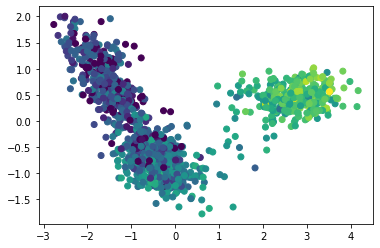

In [28]:
plt.scatter(pca_psix.T[0], pca_psix.T[1], c=np.log10(tiklova_mrna.loc['Snap25']+1))

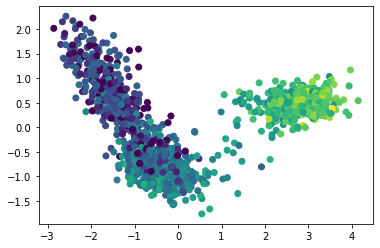

In [29]:
plt.scatter(pca_kw.T[0], pca_kw.T[1], c=np.log10(tiklova_mrna.loc['Snap25']+1))

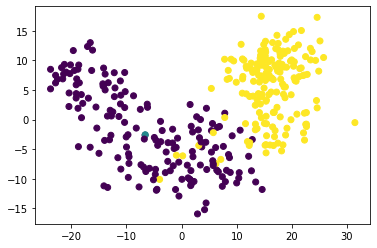

In [9]:
# Exon good for Psix, not for KW
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Dst_5', tiklova_neurogenesis_rd.index])

In [5]:
def get_ranks(scores_df, score_name, bins=50):
    score_series = scores_df.sort_values(score_name).sort_values(score_name)
    ranks_dict = dict()
    total_exons = len(scores_df.index)
    exons_per_rank = int(total_exons/bins)
    for i in range(bins):
        bin_str = i+1
        bin_lims = -exons_per_rank*i
        if i == bins - 1:
            rank_exons = scores_df.sort_values(score_name).index[:bin_lims]
        elif i == 0:
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:]
        else:
            
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:bin_lims]
        ranks_dict.update({bin_str:rank_exons})
    return ranks_dict
    

def make_comparison(df1, df2, score1, score2, bins=50):
    
    rank_df = pd.DataFrame()
    rank_df_exons = pd.DataFrame()
    
    ranks1 = get_ranks(df1, score1, bins)
    ranks2 = get_ranks(df2, score2, bins)
    
    for i in range(1, bins+1):
        shared_list = []
        shared_exons_list = []
        r1_i = ranks1[i]
        for j in range(1, bins+1):
            r2_j = ranks2[j]
            
            shared = len(r1_i & r2_j)
            
            shared_list.append(len(r1_i & r2_j))
            shared_exons_list.append(r1_i & r2_j)
            
        rank_df['bin_' + str(i)] = shared_list
        rank_df_exons['bin_' + str(i)] = shared_exons_list
        
    rank_df.index = ['bin_' + str(i) for i in range(1, bins+1)]
    rank_df_exons.index = ['bin_' + str(i) for i in range(1, bins+1)]
    
    return rank_df, rank_df_exons
        

Text(50.0, 0.5, 'Psix ranks')

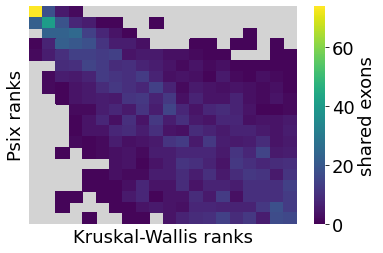

In [6]:
comparison, comparison_exons = make_comparison(tiklova_kw.loc[tiklova_psix.index], tiklova_psix.loc[tiklova_psix.index],
                             'KW_score', 'L_score', bins=20)
mask = comparison == 0
                             
g = sns.heatmap(comparison, mask=mask, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
# g = sns.heatmap(comparison, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
                yticklabels=False, xticklabels=False)
g.set_facecolor('lightgray')

# g.tick_params(labelsize=0)
g.figure.axes[-1].tick_params(labelsize=18)
g.figure.axes[-1].yaxis.label.set_size(18)

plt.xlabel('Kruskal-Wallis ranks', fontsize=18)
plt.ylabel('Psix ranks', fontsize=18)

In [7]:
psix_good = pd.Index([])
for bin_good in ['bin_'+str(x) for x in range(1, 11)]:
    for bin_bad in ['bin_'+str(x) for x in range(11, 21)]:

        psix_good = psix_good | comparison_exons.loc[bin_good, bin_bad]
        
kw_good = pd.Index([])
for bin_good in ['bin_'+str(x) for x in range(1, 11)]:
    for bin_bad in ['bin_'+str(x) for x in range(11, 21)]:

        kw_good = kw_good | comparison_exons.loc[bin_bad, bin_good]

(array([ 6.,  7., 11., 15., 21., 21., 24., 28., 34., 37.]),
 array([0.01169591, 0.08538012, 0.15906433, 0.23274854, 0.30643275,
        0.38011696, 0.45380117, 0.52748538, 0.60116959, 0.6748538 ,
        0.74853801]),
 <a list of 10 Patch objects>)

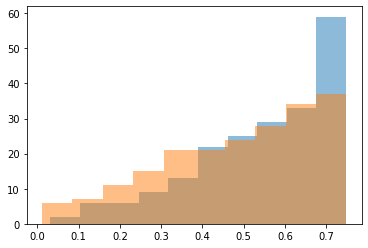

In [19]:
plt.hist(tiklova_PSI.loc[psix_good].isna().mean(axis=1), alpha=0.5)
plt.hist(tiklova_PSI.loc[kw_good].isna().mean(axis=1), alpha=0.5)

In [20]:
tiklova_PSI.loc[psix_good].mean()

SRR7408400    0.698626
SRR7408401    0.704989
SRR7408404    0.698433
SRR7408413    0.680108
SRR7408414    0.608913
                ...   
SRR7410092    0.641621
SRR7410093    0.642981
SRR7410094    0.672074
SRR7410096    0.690263
SRR7410097    0.651092
Length: 1197, dtype: float64

In [8]:
from sklearn.impute import KNNImputer

In [47]:
df = pd.DataFrame(KNNImputer().fit_transform(tiklova_PSI.loc[psix_good]))
df.index = psix_good

In [62]:
W

NameError: name 'W' is not defined

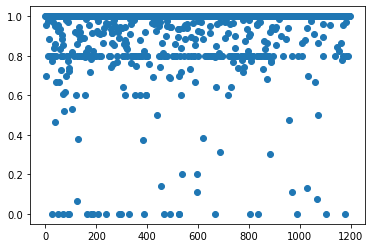

In [52]:
plt.scatter(range(len(df.columns)), df.loc[psix_good[0]])

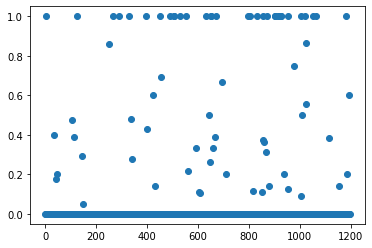

In [50]:
plt.scatter(range(len(tiklova_PSI.columns)), tiklova_PSI.loc[psix_good[1]])

In [58]:
pca_psix = PCA().fit_transform(tiklova_PSI.loc[psix_good].T.fillna(tiklova_PSI.loc[psix_good].T.mean()))
pca_kw = PCA().fit_transform(tiklova_PSI.loc[kw_good].T.fillna(tiklova_PSI.loc[kw_good].T.mean()))

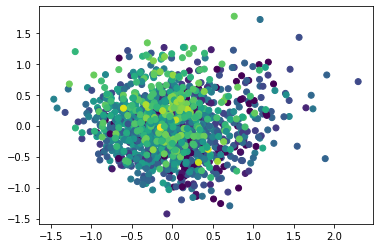

In [59]:
plt.scatter(pca_kw.T[0], pca_kw.T[1], c=np.log10(tiklova_mrna.loc['Snap25']+1))

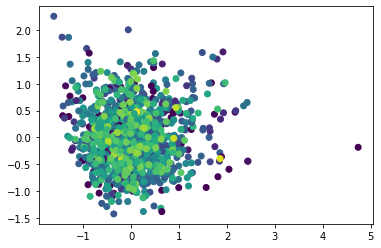

In [60]:
plt.scatter(pca_psix.T[0], pca_psix.T[1], c=np.log10(tiklova_mrna.loc['Snap25']+1))

In [9]:
from sklearn.neighbors import NearestNeighbors
def get_distance_matrix(pca, k=100):
    print('token of change')
    nbrs = NearestNeighbors(n_neighbors=k).fit(pca)
    distances, indices = nbrs.kneighbors(pca)
    
    cells = list(pca.index)
    
    W = pd.DataFrame(np.zeros((len(cells), len(cells))))
    W.columns = cells
    W.index = cells
    
    for i in tqdm(range(len(cells))):
        cell_i = cells[i]
        sigma = np.max(distances[i])
        for j in range(1, len(distances[i])):
            cell_j = cells[indices[i][j]]
            d = distances[i][j]
            w = np.exp(-(d**2)/(sigma**2))        
            W.loc[cell_i, cell_j] = w
    
    return W


W = get_distance_matrix(tiklova_neurogenesis_rd[['PC_1', 'PC_2']], k=100)

  0%|          | 5/1197 [00:00<00:28, 41.57it/s]

token of change


100%|██████████| 1197/1197 [00:24<00:00, 49.36it/s]


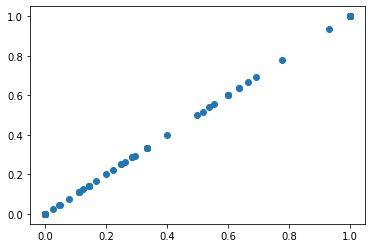

In [83]:

plt.scatter(tiklova_PSI.loc[psix_exons[0]],
            (np.array(tiklova_PSI.loc[psix_exons[0]]) * (np.array(W)).sum()) / np.array(W).sum())

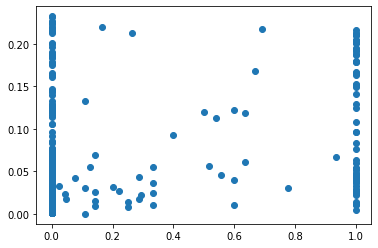

In [98]:
plt.scatter(tiklova_PSI.loc[psix_exons[0]],
            pd.DataFrame(np.array(W) *np.array(tiklova_PSI.loc[psix_exons[0]])).sum(axis=1)/np.array(W.sum(axis=1)))

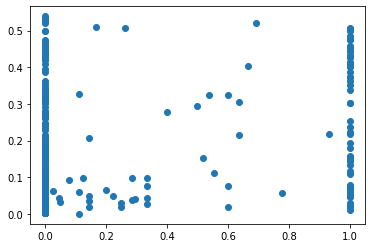

In [99]:
x = tiklova_PSI.loc[psix_exons[0]].dropna().index
plt.scatter(tiklova_PSI.loc[psix_exons[0], x],
            pd.DataFrame(np.array(W.loc[x, x]) *np.array(tiklova_PSI.loc[psix_exons[0], x])).sum(axis=1)/np.array(W.loc[x, x].sum(axis=1)))

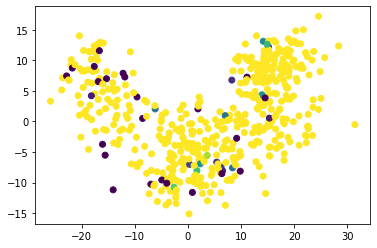

In [112]:
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, c=tiklova_PSI.loc[psix_good[0]])

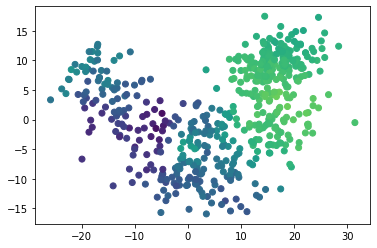

In [113]:
plt.scatter(tiklova_neurogenesis_rd.loc[x].PC_1, tiklova_neurogenesis_rd.loc[x].PC_2, 
            c=pd.DataFrame(np.array(W.loc[x, x]) *np.array(tiklova_PSI.loc[psix_good[0], x])).sum(axis=1)/np.array(W.loc[x, x].sum(axis=1)),
           vmax=1, vmin=0)

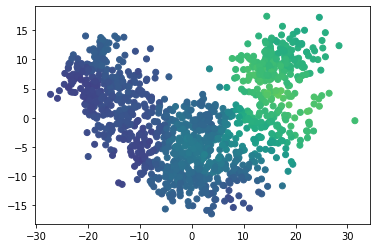

In [114]:
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=pd.DataFrame(np.array(W) *np.array(tiklova_PSI.loc[psix_good[0]])).sum(axis=1)/np.array(W.sum(axis=1)),
           vmax=1, vmin=0)

In [10]:
psix_imputed = pd.DataFrame()
for exon in tqdm(psix_good):
    exon_df = pd.DataFrame()
    x = tiklova_PSI.loc[exon].dropna().index
    W_e = W.loc[x, x]
    psi_o = tiklova_PSI.loc[exon, x]
    neigh_average = pd.DataFrame(np.array(W_e) *np.array(psi_o)).sum(axis=1)/np.array(W_e.sum(axis=1))
    
    exon_df[exon] = neigh_average
    exon_df.index = x
    
    psix_imputed = pd.concat([psix_imputed, exon_df], axis=1, sort=False)
    
psix_imputed = psix_imputed.loc[tiklova_neurogenesis_rd.index]

100%|██████████| 204/204 [00:02<00:00, 69.00it/s]


In [11]:
kw_imputed = pd.DataFrame()
for exon in tqdm(kw_good):
    exon_df = pd.DataFrame()
    x = tiklova_PSI.loc[exon].dropna().index
    W_e = W.loc[x, x]
    psi_o = tiklova_PSI.loc[exon, x]
    neigh_average = pd.DataFrame(np.array(W_e) *np.array(psi_o)).sum(axis=1)/np.array(W_e.sum(axis=1))
    
    exon_df[exon] = neigh_average
    exon_df.index = x
    
    kw_imputed = pd.concat([kw_imputed, exon_df], axis=1, sort=False)
    
kw_imputed = kw_imputed.loc[tiklova_neurogenesis_rd.index]

100%|██████████| 204/204 [00:02<00:00, 78.60it/s]


In [176]:
# pca_psix = PCA().fit_transform(KNNImputer().fit_transform(psix_imputed))
# pca_kw = PCA().fit_transform(KNNImputer().fit_transform(kw_imputed))

In [177]:
pca_psix = PCA().fit_transform(psix_imputed.fillna(psix_imputed.mean()))
pca_kw = PCA().fit_transform(kw_imputed.fillna(kw_imputed.mean()))

In [178]:
pca_psix = pd.DataFrame(pca_psix)
pca_psix = pca_psix[pca_psix.columns[:2]]
pca_psix.columns = ['PC_1', 'PC_2']
pca_psix.index = psix_imputed.index
pca_psix = pca_psix.loc[tiklova_neurogenesis_rd.index]

pca_kw = pd.DataFrame(pca_kw)
pca_kw = pca_kw[pca_kw.columns[:2]]
pca_kw.columns = ['PC_1', 'PC_2']
pca_kw.index = kw_imputed.index
pca_kw = pca_kw.loc[tiklova_neurogenesis_rd.index]

In [190]:
psix_imputed.fillna(psix_imputed.mean()).T[tiklova_neurogenesis_rd.index]

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
Aasdhppt_2,0.934195,0.867737,0.934195,0.813532,0.934195,0.934195,0.934195,0.839776,0.853042,0.934195,...,0.934195,0.934195,0.976781,0.934195,0.959132,0.985423,1.000000,0.962863,0.950028,0.948085
Anapc16_4,0.065029,0.039756,0.065029,0.000000,0.040315,0.065029,0.032506,0.065029,0.065029,0.065029,...,0.055440,0.157336,0.105658,0.065029,0.084169,0.111308,0.065029,0.081144,0.050868,0.089221
Angel2_3,0.859643,0.979149,0.890940,0.890940,0.890940,0.890940,0.890940,0.890940,0.982011,0.890940,...,0.890940,0.890940,0.890940,0.890940,0.890940,0.960000,0.890940,0.890940,0.828414,0.737367
Ankrd16_nmdSE_1,0.392476,0.392476,0.439039,0.392476,0.392476,0.392476,0.392476,0.392476,0.392476,0.442337,...,0.430032,0.392476,0.466057,0.392476,0.344546,0.425035,0.400187,0.378617,0.421398,0.392476
Ankrd16_nmdSE_2,0.344941,0.344941,0.344941,0.344941,0.344941,0.344941,0.344941,0.344941,0.344941,0.407927,...,0.395948,0.344941,0.445380,0.344941,0.323345,0.393372,0.335372,0.308803,0.375035,0.344941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zfp266_8,0.907172,0.907172,0.950687,0.907172,0.968342,0.970092,0.957025,0.878268,0.980515,0.907172,...,0.947980,0.907172,0.982764,0.876994,0.937480,0.907172,0.907172,0.909905,0.920984,0.944285
Zfp280d_nmdSE_3,0.088839,0.088839,0.088839,0.088839,0.088839,0.088839,0.088839,0.057664,0.088839,0.088839,...,0.044272,0.088839,0.088436,0.088839,0.114363,0.088839,0.069325,0.088839,0.088839,0.088839
Zfp558_1,0.750754,0.872021,0.872021,0.872021,0.872021,0.872021,0.732306,0.872021,0.872021,0.771792,...,0.872021,0.872021,0.872021,0.872021,0.872021,0.872021,0.872021,0.902751,0.872021,0.872021
Zfp558_3,0.778333,0.888650,0.888650,0.888650,0.888650,0.888650,0.778729,0.888650,0.888650,0.818792,...,0.888650,0.888650,0.888650,0.888650,0.888650,0.888650,0.888650,0.905996,0.888650,0.888650


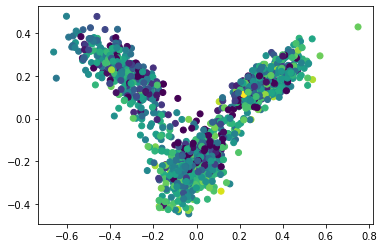

In [179]:
plt.scatter(pca_kw.PC_1, pca_kw.PC_2, c=np.log10(tiklova_mrna.loc['Ptbp2']+1))

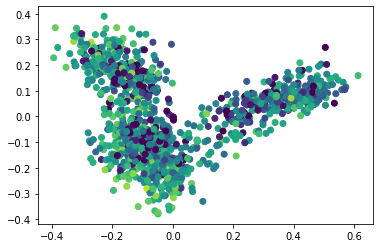

In [180]:
plt.scatter(pca_psix.PC_1, pca_psix.PC_2, c=np.log10(tiklova_mrna.loc['Ptbp2']+1))

In [164]:
plt.scatter(pca_psix.PC_1, pca_psix.PC_2, c=tiklova_PSI.loc['Rbfox2'])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [181]:
key_regulators = ['Nova1', 'Nova2', 'Rbfox1', 'Rbfox2', 'Rbfox3', 'Mbnl1', 'Mbnl2', 'Ptbp1', 'Ptbp2']

In [12]:
psix_good_psi = tiklova_PSI.loc[psix_good].T
psix_good_psi = psix_good_psi.fillna(psix_good_psi.mean()).T[tiklova_neurogenesis_rd.index]
# kw_imputed.fillna(kw_imputed.mean()).T[tiklova_neurogenesis_rd.index]
import hotspot
hs = hotspot.Hotspot(psix_good_psi, 
                     model='none', latent=tiklova_neurogenesis_rd)

hs.create_knn_graph(weighted_graph=False, n_neighbors=100)
hs_results_psix = hs.compute_autocorrelations()


hs_results_psix.sort_values('Z')

100%|██████████| 204/204 [00:00<00:00, 301.05it/s]


,C,Z,Pval,FDR
Gene,,,,
Rusc2_5,0.097491,0.679188,0.248509,0.248509
Kctd17_nmdSE_1,0.166884,0.701977,0.241347,0.242535
Tpp2_2,0.156539,0.741741,0.229122,0.231391
Epn2_5,0.166771,0.743958,0.228451,0.231391
Kcna6_1,0.183118,0.864457,0.193669,0.197542
...,...,...,...,...
Pdss2_2,0.987252,231.570288,0.000000,0.000000
Rundc3b_1,0.982926,231.640150,0.000000,0.000000
Ptcd3_10,0.982639,231.649354,0.000000,0.000000


In [13]:
kw_good_psi = tiklova_PSI.loc[kw_good].T
kw_good_psi = kw_good_psi.fillna(kw_good_psi.mean()).T[tiklova_neurogenesis_rd.index]
# kw_imputed.fillna(kw_imputed.mean()).T[tiklova_neurogenesis_rd.index]
import hotspot
hs = hotspot.Hotspot(kw_good_psi, 
                     model='none', latent=tiklova_neurogenesis_rd)

hs.create_knn_graph(weighted_graph=False, n_neighbors=100)
hs_results_kw = hs.compute_autocorrelations()


hs_results_kw.sort_values('Z')

100%|██████████| 204/204 [00:00<00:00, 4892.63it/s]


,C,Z,Pval,FDR
Gene,,,,
Rbm25_4,0.093344,0.647984,0.258498,0.258498
Atat1_nmdSE_1,0.104874,0.696462,0.243070,0.244267
Rnf167_nmdSE_1,0.118265,0.717790,0.236443,0.238784
Hsph1_4,0.141764,0.749450,0.226793,0.230178
Atp5h_4,0.106452,0.808124,0.209510,0.213700
...,...,...,...,...
Dctn5_2,0.973399,231.131426,0.000000,0.000000
Use1_2,0.974369,231.255073,0.000000,0.000000
Phf20_1,0.983183,231.666741,0.000000,0.000000


(array([48.,  8.,  7.,  3.,  8.,  7.,  6., 17., 29., 71.]),
 array([  0.64798428,  23.81183634,  46.9756884 ,  70.13954045,
         93.30339251, 116.46724456, 139.63109662, 162.79494867,
        185.95880073, 209.12265278, 232.28650484]),
 <a list of 10 Patch objects>)

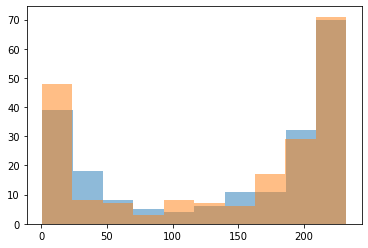

In [14]:
plt.hist(hs_results_psix.Z, alpha=0.5)
plt.hist(hs_results_kw.Z, alpha=0.5)

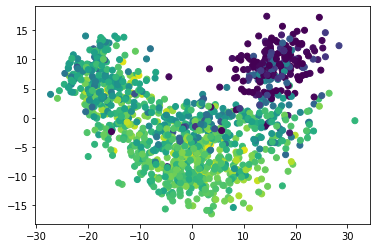

In [46]:
# Exon good for Psix, not for KW
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=np.log10(tiklova_mrna.loc['Nnat', tiklova_neurogenesis_rd.index]+1))